# **Récupération, pré-traitement et analyse de posts Reddit en rapport avec l'entreprise Apple afin de conduire une analyse de sentiments**

L'objectif de cette partie est de **récupérer des posts Reddit** relatifs à Apple afin de les **analyser** et de pouvoir les incorporer à notre **algorithme de trading final** sous forme d'une aide à la décision.

On va d'abord **importer** naïvement les derniers posts relatifs à Apple à l'aide de l'**API de Reddit**. On va ensuite trier ces données, les nettoyer et faire un ensemble de **statistiques descriptives** sur les posts nettoyés. Nous allons d'abord observer un nuage de mots sur les titres des derniers posts. Puis, nous créerons un dataframe regroupant les derniers posts, leur auteur, leur date de publication, leur titre ainsi que leur URL.

Par suite, nous observerons le lien qui peut exister entre le nombre de posts publiés et le cours d'Apple en bourse.

Puis nous déterminerons l'influence de certains auteurs dans le nombre de posts écrits.

Enfin, nous réaliserons des statistiques descriptives sur le dataframe créé initialment.


Tout d'abord, on installe **praw** et **wordcloud** qui seront deux bibliothèques essentielles pour la suite de ce notebook.

In [ ]:
pip install praw wordcloud

On importe aussi toutes les **bibliothèques** qui nous seront utiles :

In [1]:
import praw
import pandas as pd
import numpy as np
from wordcloud import WordCloud,  STOPWORDS
import matplotlib.pyplot as plt
import re
from collections import Counter

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

/Users/dabadieraphael/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


On importe également les fonctions codées dans les fichiers précédents et qui nous seront à nouveau utiles ici :

In [2]:
def cleaning_text(text):
    #Passage du texte en miniscules
    text=text.lower()
    #Suppression des chiffres
    text=re.sub(r'\d+', '', text)
    #Suppresion de /r/
    text =re.sub(r'/r/', '', text)
    #Suppression de la ponctuation et des symboles spéciaux
    text=re.sub(r'[^\w\s]', '', text)
    return text


def count_common_words(text):
    words=text.split()
    dict={}
    for el in words :
        if el not in dict:
            dict[el]=1
        else:
            dict[el]+=1
    return dict

def most_common_words(dictionary):
    sorted_dict=dict(sorted(dictionary.items(), key=lambda item: item[1], reverse=True))
    return sorted_dict



def combine_dictionaries(df,df_column_name):
    combined_dict={}
    column_index=df.columns.get_loc(str(df_column_name))
    for i in range(len(df)):
        temp_dictionary=df.iloc[i,int(column_index)]

        for key, value in temp_dictionary.items():
            if key not in combined_dict:
                combined_dict[key]=value
            else:
                combined_dict[key]+=value
    return combined_dict

stops = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
def clean_stopwords(text):
    words = word_tokenize(text)
    cleaned_text=[word for word in words if word not in stops]
    return ' '.join(cleaned_text)

# I/ **Récupération des articles sous forme d'un dataframe**

Nous allons d'abord observer les mots les plus utilisés dans les titres des 500 derniers posts relatifs à Apple. Puis, nous allons créer et nettoyer un dataframe regroupant les informations principales concernants les posts concernant Apple. Pour ce faire, nous utilisons l'API de Reddit. Nous avons,préalablement, créé un profit "programmeur" sur Reddit. Ce profit permet d'obtenir l'identification client et le mot de passe, qui donnent la possibilité d'importer les données de Reddit.

##  Nuage de mots des 500 derniers posts sur Apple

On fait les configurations nécessaires à l'utilisation de PRAW pour la récupération des posts:

In [3]:
reddit = praw.Reddit(client_id='xIq0ALkJ0RWzM5ZLwwiQKA',
                     client_secret='DeHliktGK8nfhDXsJFiebqgeZKhHXQ',
                     user_agent='Matlpg')

On récupère les 500 premiers posts du subreddit 'apple' :

In [4]:
subreddit = reddit.subreddit('apple')
top_posts = subreddit.new(limit=500) #On récupère ainsi les 500 derniers posts Reddit sur Apple

In [5]:
#Création d'un dataframe 
posts_data = []
for post in top_posts:
    text = post.selftext if post.selftext else "Text Not Available"
    date = pd.to_datetime(post.created_utc, unit='s')
    post_data = {
        "Titre": post.title,
        "Auteur": str(post.author),
        "Texte": text,
        "Date": date,
        "url": post.url
    }
    posts_data.append(post_data)

df = pd.DataFrame(posts_data)

On nettoie le texte récupéré :

In [6]:
df['Cleaned_text']=df['Texte'].apply(cleaning_text)
df['Cleaned_text']=df['Cleaned_text'].apply(clean_stopwords)

df.head()

,Titre,Auteur,Texte,Date,url,Cleaned_text
0,"Daily Advice Thread - December 29, 2023",AutoModerator,Welcome to the Daily Advice Thread for /r/Appl...,2023-12-29 11:00:34,https://www.reddit.com/r/apple/comments/18tkm9...,welcome daily advice thread apple thread used ...
1,Swipe on Dynamic Island (is this well known?) ...,safereddddditer175,\nIs this a well known feature? In MKBHD’s lat...,2023-12-29 10:08:57,https://youtu.be/YmwskGLycHo?si=oKM--J62UM7SE_hH,well known feature mkbhds latest iphone pro re...
2,Vision Pro 2 Rumored to Gain Brighter and More...,filmantopia,Text Not Available,2023-12-28 14:55:18,https://www.macrumors.com/2023/12/28/vision-pr...,text available
3,Inside Apple's Massive Push to Transform the M...,cheesepuff07,Text Not Available,2023-12-28 14:53:36,https://www.inverse.com/tech/mac-gaming-apple-...,text available
4,"Daily Advice Thread - December 28, 2023",AutoModerator,Welcome to the Daily Advice Thread for /r/Appl...,2023-12-28 11:00:30,https://www.reddit.com/r/apple/comments/18srcx...,welcome daily advice thread apple thread used ...


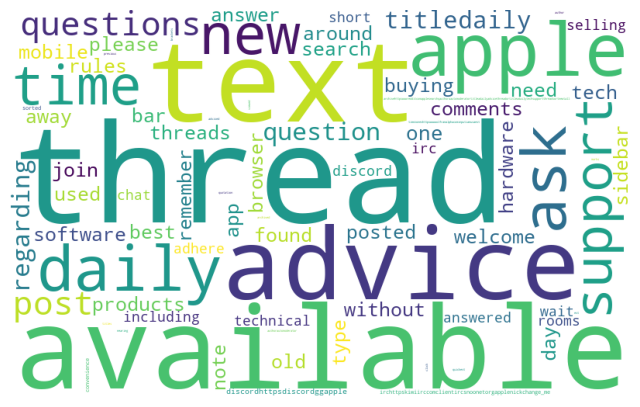

In [7]:
text=' '.join(df['Cleaned_text'])
words=text.split()
word_counts=Counter(words)
wordcloud = WordCloud(width = 800, height = 500, background_color ='white').generate_from_frequencies(word_counts)

plt.figure(figsize = (8, 8)) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.show()

"**Advice thread**" revient très souvent. En effet, on remarque en analysant le dataframe, qu'un user publie **le même post** chaque jour avec à chaque fois ce titre. Nous pouvons l'enlever. 
Par ailleurs, on constate que de nombreux articles ne contiennent pas de texte. Ces derniers contiennent généralement un **lien** vers un article de presse extérieur à Reddit. Afin de récupérer du contenu plus intéressant, nous allons récupérer les **commentaires principaux** sous chacun des posts récupérés. Ce sont eux qui seront analysés par notre modèle de NLP.

## Récupération des commentaires principaux :

On supprime les posts avec un "text not available"

In [13]:
df = df[~df['Texte'].str.contains("Text Not Available")]
df.head()

,Titre,Auteur,Texte,Date,url,Cleaned_text,Top_Commentaires,comment_1,comment_2,comment_3,comment_4,comment_5
0,"Daily Advice Thread - December 29, 2023",AutoModerator,Welcome to the Daily Advice Thread for /r/Appl...,2023-12-29 11:00:34,https://www.reddit.com/r/apple/comments/18tkm9...,welcome daily advice thread apple thread used ...,[I recently sent off my Apple Watch for repair...,I have a M1 Macbook Air 13 that I love but it'...,I’m looking into buying a Studio Display to pa...,"If you invite people into Family Sharing, does...",Are there any good third party Lightning to Di...,I recently sent off my Apple Watch for repair ...
1,Swipe on Dynamic Island (is this well known?) ...,safereddddditer175,\nIs this a well known feature? In MKBHD’s lat...,2023-12-29 10:08:57,https://youtu.be/YmwskGLycHo?si=oKM--J62UM7SE_hH,well known feature mkbhds latest iphone pro re...,,nan,nan,nan,nan,nan
4,"Daily Advice Thread - December 28, 2023",AutoModerator,Welcome to the Daily Advice Thread for /r/Appl...,2023-12-28 11:00:30,https://www.reddit.com/r/apple/comments/18srcx...,welcome daily advice thread apple thread used ...,,I just impulsively upgraded from an iPhone 12 ...,I am seriously considering purchasing two Appl...,App Store Always Requiring Password\n\nWhy is ...,I have a files app on my iPhone that no longer...,I've read a few threads regarding this and rea...
12,"Daily Advice Thread - December 27, 2023",AutoModerator,Welcome to the Daily Advice Thread for /r/Appl...,2023-12-27 11:00:35,https://www.reddit.com/r/apple/comments/18ry7z...,welcome daily advice thread apple thread used ...,,So we are off on vacation so I don't have my m...,"Hey all, I'm looking for some help comparing n...",Looking at getting [this 9th gen ipad from BBu...,Is new apple ID registration down? My mom gave...,Mac OS Monterey: can a third party non-stock p...
19,"Daily Advice Thread - December 26, 2023",AutoModerator,Welcome to the Daily Advice Thread for /r/Appl...,2023-12-26 11:00:28,https://www.reddit.com/r/apple/comments/18r5ri...,welcome daily advice thread apple thread used ...,,I'm helping my mom troubleshoot some payment i...,"I just got a new 14"" MacBook Pro for work. Wha...","I have an iPhone 15 Pro Max, I went to GameSto...","I own two iPhones (both are iPhone 11, if it's...",When is the new Magic Keyboard coming out and ...


On récupère les commentaires principaux.

In [14]:
def extract_submission_id(url):
    # Utilisation d'une expression régulière pour extraire l'ID de la soumission
    match = re.search(r'/comments/(\w+)/', url)
    # Si l'expression régulière trouve un match, retourner l'ID, sinon retourner None
    return match.group(1) if match else None

def get_top_comments(url):
    submission_id = extract_submission_id(url)
    
    # Vérifier si submission_id est valide
    if not submission_id:
        print(f"Erreur pour '{url}'")
        return []
    
    # Si submission_id est valide, continuer à récupérer les commentaires
    submission = reddit.submission(id=submission_id)
    submission.comment_sort = 'top'
    submission.comments.replace_more(limit=0)
    
    top_comments = []
    for comment in submission.comments[:5]:  # Prendre les 5 premiers commentaires
        top_comments.append(comment.body)
    
    return top_comments


for index, row in df.iterrows():
    top_comments = get_top_comments(row['url'])
    for i, comment in enumerate(top_comments):
        df.loc[index, f'comment_{i+1}'] = comment

L'ID de la soumission extrait de l'URL 'https://youtu.be/YmwskGLycHo?si=oKM--J62UM7SE_hH' est invalide.
L'ID de la soumission extrait de l'URL 'http://photorealityar.com/spatialcatvideos.html' est invalide.
L'ID de la soumission extrait de l'URL 'https://www.theverge.com/2023/12/21/24011536/apple-watch-ban-series-repairs-replacements' est invalide.
L'ID de la soumission extrait de l'URL 'https://kalshi.com/markets/visionpro/apple-vision-pro-release-date' est invalide.
L'ID de la soumission extrait de l'URL 'https://www.apple.com/newsroom/2023/12/the-athletic-joins-apple-news-plus/' est invalide.
L'ID de la soumission extrait de l'URL 'https://support.apple.com/en-in/airpods-pro-service-program-sound-issues' est invalide.
L'ID de la soumission extrait de l'URL 'https://youtu.be/WK_AtW66XI0?si=UnOzUCwf-ycjYS07' est invalide.
L'ID de la soumission extrait de l'URL 'https://www.apple.com/newsroom/2023/12/apple-marks-world-aids-day-with-red/' est invalide.
L'ID de la soumission extrait de l

On supprime tous les articles pour lesquels la récupération des commentaires n'a pas pu se faire.

In [17]:
df.replace('nan', np.nan, inplace=True) #Il y avait un problème avec le formatage précédent des 'nan'
df = df.dropna(axis=0, subset=['comment_1', 'comment_2', 'comment_3', 'comment_4', 'comment_5'])
df.head()

,Titre,Auteur,Texte,Date,url,Cleaned_text,Top_Commentaires,comment_1,comment_2,comment_3,comment_4,comment_5
0,"Daily Advice Thread - December 29, 2023",AutoModerator,Welcome to the Daily Advice Thread for /r/Appl...,2023-12-29 11:00:34,https://www.reddit.com/r/apple/comments/18tkm9...,welcome daily advice thread apple thread used ...,[I recently sent off my Apple Watch for repair...,I have a M1 Macbook Air 13 that I love but it'...,I’m looking into buying a Studio Display to pa...,"If you invite people into Family Sharing, does...",Are there any good third party Lightning to Di...,I recently sent off my Apple Watch for repair ...
4,"Daily Advice Thread - December 28, 2023",AutoModerator,Welcome to the Daily Advice Thread for /r/Appl...,2023-12-28 11:00:30,https://www.reddit.com/r/apple/comments/18srcx...,welcome daily advice thread apple thread used ...,,I just impulsively upgraded from an iPhone 12 ...,I am seriously considering purchasing two Appl...,App Store Always Requiring Password\n\nWhy is ...,I have a files app on my iPhone that no longer...,I've read a few threads regarding this and rea...
12,"Daily Advice Thread - December 27, 2023",AutoModerator,Welcome to the Daily Advice Thread for /r/Appl...,2023-12-27 11:00:35,https://www.reddit.com/r/apple/comments/18ry7z...,welcome daily advice thread apple thread used ...,,So we are off on vacation so I don't have my m...,"Hey all, I'm looking for some help comparing n...",Looking at getting [this 9th gen ipad from BBu...,Is new apple ID registration down? My mom gave...,Mac OS Monterey: can a third party non-stock p...
19,"Daily Advice Thread - December 26, 2023",AutoModerator,Welcome to the Daily Advice Thread for /r/Appl...,2023-12-26 11:00:28,https://www.reddit.com/r/apple/comments/18r5ri...,welcome daily advice thread apple thread used ...,,I'm helping my mom troubleshoot some payment i...,"I just got a new 14"" MacBook Pro for work. Wha...","I have an iPhone 15 Pro Max, I went to GameSto...","I own two iPhones (both are iPhone 11, if it's...",When is the new Magic Keyboard coming out and ...
24,"Daily Advice Thread - December 25, 2023",AutoModerator,Welcome to the Daily Advice Thread for /r/Appl...,2023-12-25 11:00:41,https://www.reddit.com/r/apple/comments/18qgkw...,welcome daily advice thread apple thread used ...,,Does anyone know when the Airpods Pro were upd...,A month ago I realized that I needed to do som...,"as im sure others have, i got a new phone toda...","So I got an e-mail ""Your Apple ID information ...",Someone used my credit card to buy a $100 gift...


On nettoie le texte des commentaires principaux récupérés

In [18]:
df['comment_1_clean'] = df['comment_1'].apply(cleaning_text)
df['comment_2_clean'] = df['comment_2'].apply(cleaning_text)
df['comment_3_clean'] = df['comment_3'].apply(cleaning_text)
df['comment_4_clean'] = df['comment_4'].apply(cleaning_text)
df['comment_5_clean'] = df['comment_5'].apply(cleaning_text)

df.head()

,Titre,Auteur,Texte,Date,url,Cleaned_text,Top_Commentaires,comment_1,comment_2,comment_3,comment_4,comment_5,comment_1_clean,comment_2_clean,comment_3_clean,comment_4_clean,comment_5_clean
0,"Daily Advice Thread - December 29, 2023",AutoModerator,Welcome to the Daily Advice Thread for /r/Appl...,2023-12-29 11:00:34,https://www.reddit.com/r/apple/comments/18tkm9...,welcome daily advice thread apple thread used ...,[I recently sent off my Apple Watch for repair...,I have a M1 Macbook Air 13 that I love but it'...,I’m looking into buying a Studio Display to pa...,"If you invite people into Family Sharing, does...",Are there any good third party Lightning to Di...,I recently sent off my Apple Watch for repair ...,i have a m macbook air that i love but its be...,im looking into buying a studio display to pai...,if you invite people into family sharing does ...,are there any good third party lightning to di...,i recently sent off my apple watch for repair ...
4,"Daily Advice Thread - December 28, 2023",AutoModerator,Welcome to the Daily Advice Thread for /r/Appl...,2023-12-28 11:00:30,https://www.reddit.com/r/apple/comments/18srcx...,welcome daily advice thread apple thread used ...,,I just impulsively upgraded from an iPhone 12 ...,I am seriously considering purchasing two Appl...,App Store Always Requiring Password\n\nWhy is ...,I have a files app on my iPhone that no longer...,I've read a few threads regarding this and rea...,i just impulsively upgraded from an iphone to...,i am seriously considering purchasing two appl...,app store always requiring password\n\nwhy is ...,i have a files app on my iphone that no longer...,ive read a few threads regarding this and read...
12,"Daily Advice Thread - December 27, 2023",AutoModerator,Welcome to the Daily Advice Thread for /r/Appl...,2023-12-27 11:00:35,https://www.reddit.com/r/apple/comments/18ry7z...,welcome daily advice thread apple thread used ...,,So we are off on vacation so I don't have my m...,"Hey all, I'm looking for some help comparing n...",Looking at getting [this 9th gen ipad from BBu...,Is new apple ID registration down? My mom gave...,Mac OS Monterey: can a third party non-stock p...,so we are off on vacation so i dont have my mu...,hey all im looking for some help comparing new...,looking at getting this th gen ipad from bbuyh...,is new apple id registration down my mom gave ...,mac os monterey can a third party nonstock pre...
19,"Daily Advice Thread - December 26, 2023",AutoModerator,Welcome to the Daily Advice Thread for /r/Appl...,2023-12-26 11:00:28,https://www.reddit.com/r/apple/comments/18r5ri...,welcome daily advice thread apple thread used ...,,I'm helping my mom troubleshoot some payment i...,"I just got a new 14"" MacBook Pro for work. Wha...","I have an iPhone 15 Pro Max, I went to GameSto...","I own two iPhones (both are iPhone 11, if it's...",When is the new Magic Keyboard coming out and ...,im helping my mom troubleshoot some payment is...,i just got a new macbook pro for work what wo...,i have an iphone pro max i went to gamestop a...,i own two iphones both are iphone if its rele...,when is the new magic keyboard coming out and ...
24,"Daily Advice Thread - December 25, 2023",AutoModerator,Welcome to the Daily Advice Thread for /r/Appl...,2023-12-25 11:00:41,https://www.reddit.com/r/apple/comments/18qgkw...,welcome daily advice thread apple thread used ...,,Does anyone know when the Airpods Pro were upd...,A month ago I realized that I needed to do som...,"as im sure others have, i got a new phone toda...","So I got an e-mail ""Your Apple ID information ...",Someone used my credit card to buy a $100 gift...,does anyone know when the airpods pro were upd...,a month ago i realized that i needed to do som...,as im sure others have i got a new phone today...,so i got an email your apple id information ha...,someone used my credit card to buy a gift car...


On supprime les posts "Advice Thread"

In [20]:
df = df[~df['Cleaned_text'].str.contains("daily advice thread", case=False, na=False)]
df.head()

,Titre,Auteur,Texte,Date,url,Cleaned_text,Top_Commentaires,comment_1,comment_2,comment_3,comment_4,comment_5,comment_1_clean,comment_2_clean,comment_3_clean,comment_4_clean,comment_5_clean
26,"One year ago, I posted about my new app, Super...",compassios,"Hi everyone,\n\nAlmost one year ago, I [posted...",2023-12-24 12:37:24,https://www.reddit.com/r/apple/comments/18pugs...,hi everyone almost one year ago posted launchh...,,I downloaded it and got the lifetime access. I...,I like it so far. Is there a connection to the...,I'm a pen and paper guy so I'm not the audienc...,"I'm genuinely impressed by this, especially co...",I’m never going to get past them being called ...,i downloaded it and got the lifetime access im...,i like it so far is there a connection to the ...,im a pen and paper guy so im not the audience ...,im genuinely impressed by this especially cons...,im never going to get past them being called c...
28,Capture – Instantly Capture Your Thoughts on iOS,Furkansimsir,"Hi Reddit 👋,\n\nAs someone constantly juggling...",2023-12-24 10:50:08,https://www.reddit.com/r/apple/comments/18psys...,hi reddit someone constantly juggling thoughts...,,i wonder what the correlation is between being...,Why would I subscribe to a notes app? There ar...,Why does this merit a subscription?,Why though? What problem is this solving?\n\nS...,Wasn't this posted last week?,i wonder what the correlation is between being...,why would i subscribe to a notes app there are...,why does this merit a subscription,why though what problem is this solving\n\nsee...,wasnt this posted last week
29,[30% OFF] Most Feature Complete Scientific Cal...,jacobp100,I’m a indie developer who since 2015 has been ...,2023-12-24 10:34:57,https://www.reddit.com/r/apple/comments/18psrh...,im indie developer since working app would rep...,,I have technicalc and use it all the time! It’...,Does it support RPN(reverse Polish notation)?,The App Store says this has in-app purchases. ...,Man I wish I knew about this app when I was do...,Just bought it and I'm loving it already.\nI c...,i have technicalc and use it all the time its ...,does it support rpnreverse polish notation,the app store says this has inapp purchases ca...,man i wish i knew about this app when i was do...,just bought it and im loving it already\ni cam...
30,I've made a personal finance app. [Self-Promot...,deniskako_,"Hey everyone, first of all merry xmas and happ...",2023-12-24 08:40:46,https://www.reddit.com/r/apple/comments/18pr9t...,hey everyone first merry xmas happy holidays w...,,I downloaded the app and was asked to review i...,Looks neat! The laurels aren’t real awards are...,"I like the design, congrats on publishing it!\...",Hi - this looks great. One question: what feat...,"""Editors Choice"", ""Finance apps we love"" - doe...",i downloaded the app and was asked to review i...,looks neat the laurels arent real awards are t...,i like the design congrats on publishing it\n\...,hi this looks great one question what feature...,editors choice finance apps we love doesnt th...
83,Made a Free Kids App About Animals [Sunday Sel...,juxtaposition0617,"Hi everyone - a few weeks ago, I posted about ...",2023-12-17 20:07:29,https://www.reddit.com/r/apple/comments/18kpx4...,hi everyone weeks ago posted kids app animals ...,,Nice to see the improvements! The usability fa...,Pretty cool. \n\nAs a French speaker I usually...,I think my son is a tad too young for this at ...,I remember seeing this! Great to see the impro...,Any plans for Apple TV?,nice to see the improvements the usability fac...,pretty cool \n\nas a french speaker i usually ...,i think my son is a tad too young for this at ...,i remember seeing this great to see the improv...,any plans for apple tv


# **II/ Analyse descriptive du dataframe**

Après avoir obtenu un dataframe nettoyé regroupant les 500 derniers posts Reddit relatifs à Apple, nous allors désormais utiliser ce dataframe pour tenter d'observer un lien entre le cours boursier d'Apple et le nombre de posts publiés. Puis nous observerons l'impact qu'ont certains utilisateurs sur le nombre de posts publiés. Enfin, nous réaliserons des statistiques descriptives sur les posts Reddit.

## Lien entre le cours d'Apple et le nombre de posts écrits

Dans cette partie, nous allons observer s'il existe, a priori, un lien entre le nombre de posts publiés sur Reddit et relatifs à Apple et le cours d'Apple en bourse.

Tout d'abord, nous allons tracer un graphe regroupant, en abscisse, le temps et, en ordonnée, le nombre de posts cumulé publiés sur Reddit.

/var/folders/pm/jc2tztb55jbddh9mt9p3ckn00000gn/T/ipykernel_54507/1874956440.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['count'] = 1  #Cette colonne sert à compter les occurences


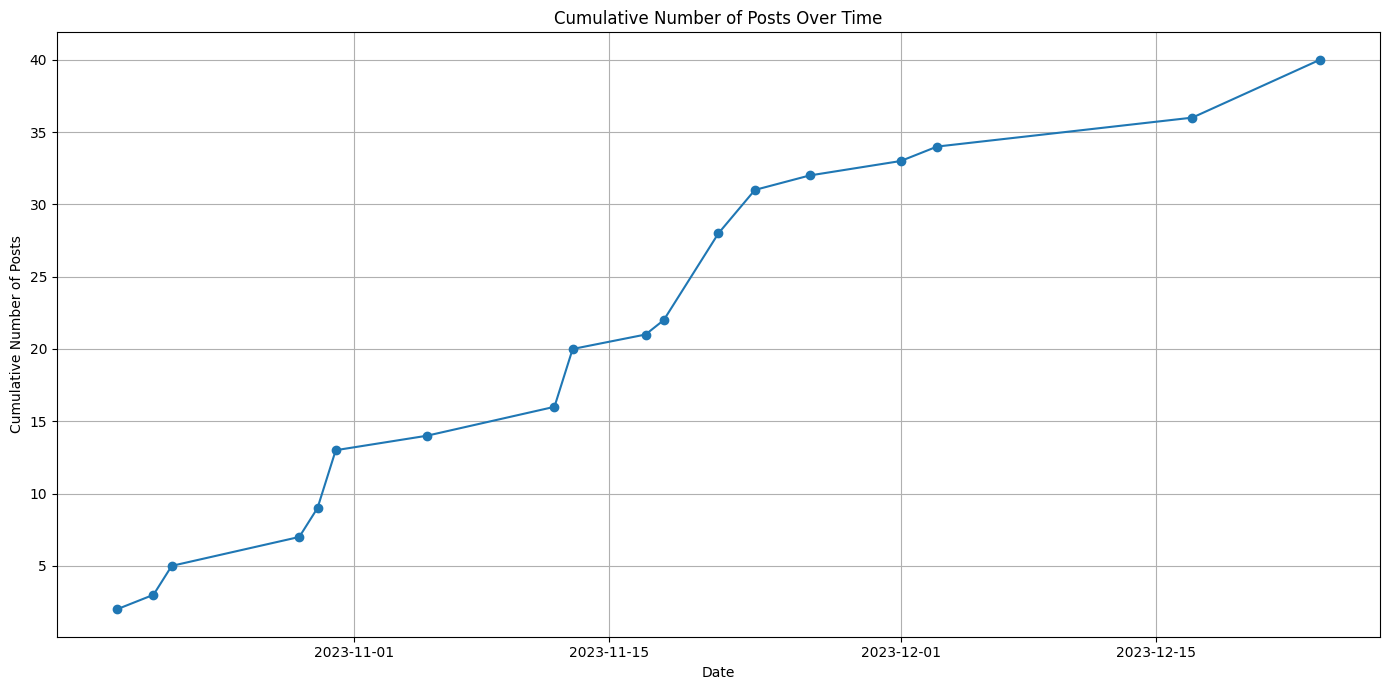

In [21]:
df['count'] = 1  #Cette colonne sert à compter les occurences
df_grouped = df.groupby(df['Date'].dt.date)['count'].sum().cumsum()

#On crée le graphique
plt.figure(figsize=(14, 7))
plt.plot(df_grouped.index, df_grouped.values, marker='o', linestyle='-')
plt.title('Cumulative Number of Posts Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Number of Posts')
plt.grid(True)
plt.tight_layout()
plt.show()

Nous observons une courbe très segmentée, qui peut être dûe à la réduction du nombre de posts observés. En effet; après nettoyage, il ne reste que 40 posts dans le dataframe.

Superposons la courbe obtenue précédemment avec **la courbe de l'indice d'Apple en bourse**. Ainsi, nous pourrons observer s'il peut y avoir un lien entre l'indice d'Apple en bourse et le nombre de posts écrits sur Reddit

[*********************100%%**********************]  1 of 1 completed


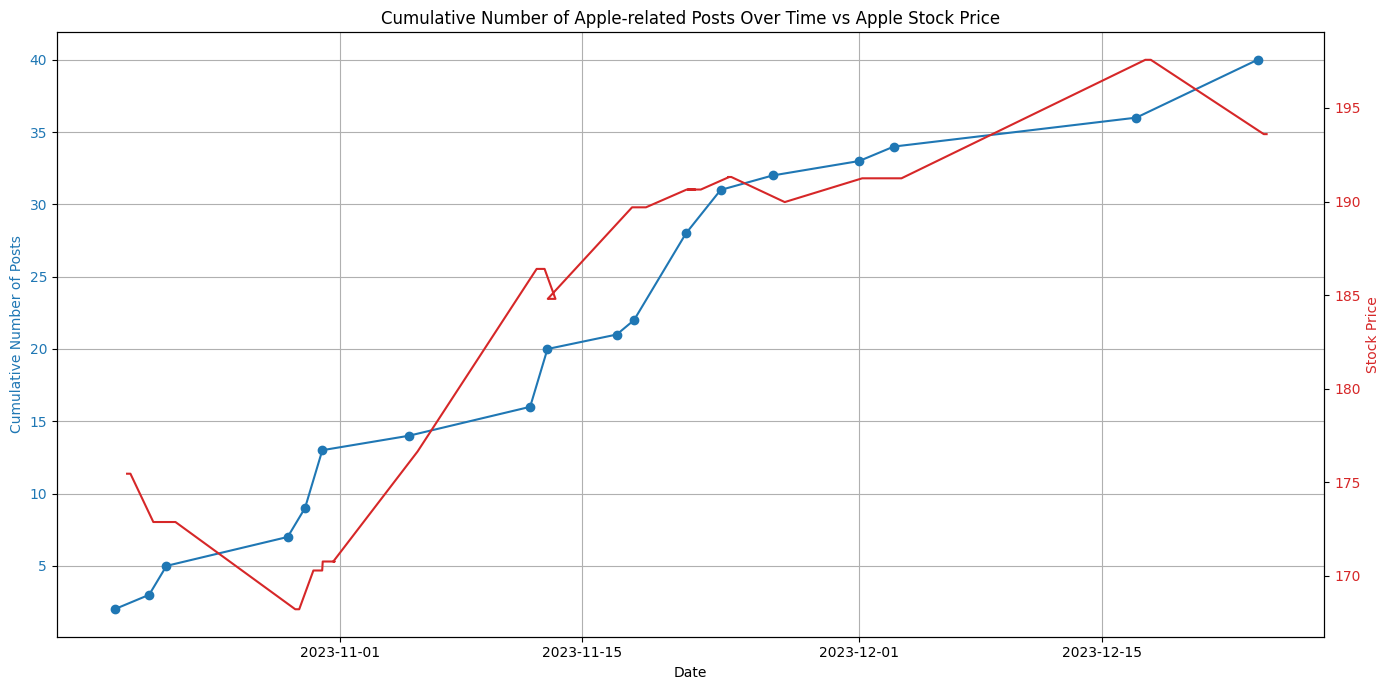

In [23]:
import yfinance as yf

# Trouver la date du post le plus ancien
oldest_post_date = df['Date'].min()

# Utiliser cette date pour télécharger les données historiques d'Apple
apple_ticker = 'AAPL'
apple_data = yf.download(apple_ticker, start=oldest_post_date)

df_apple_aligned = apple_data.reindex(df['Date'].unique(), method='ffill')


# Créer le graphe avec deux axes y
fig, ax1 = plt.subplots(figsize=(14, 7))

# Axe pour le nombre de posts
ax1.set_xlabel('Date')
ax1.set_ylabel('Cumulative Number of Posts', color='tab:blue')
ax1.plot(df_grouped.index, df_grouped.values, marker='o', linestyle='-')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True)

# Instantier un second axe y qui partage le même axe x
ax2 = ax1.twinx()
ax2.set_ylabel('Stock Price', color='tab:red')
ax2.plot(df_apple_aligned.index, df_apple_aligned['Close'], color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Titre et style
plt.title('Cumulative Number of Apple-related Posts Over Time vs Apple Stock Price')
fig.tight_layout()

plt.show()

Graphiquement, nous n'observons **pas de lien direct** entre le nombre de posts publiés et le cours d'Apple. Les deux courbes obtenues semblent totalement décorellées, ce que nous allons tenté de vérifier par suite. 

Nous allons maintenant **calculer le coefficient de correlation**, entre le nombre de posts Reddit relatifs à Apple publiés et le cours boursier d'Apple. 

In [24]:
# On réindexe le dataframe
df_apple_aligned.reset_index(inplace=True)
df_apple_aligned.rename(columns={'index': 'Date'}, inplace=True)
df_apple_aligned
# On extrait de df_apple_aligned un dataframe composé d'une colonne avec la date et le cours moyen d'Apple à cette date

# On convertit la colonne 'datetime' en type datetime
df_apple_aligned['Date'] = pd.to_datetime(df_apple_aligned['Date'])

# On extrait la date sans l'heure
df_apple_aligned['date2'] = df_apple_aligned['Date'].dt.date

# On groupe par date et calculer la moyenne du cours boursier
daily_avg_stock_data = df_apple_aligned.groupby('date2')['Close'].mean().reset_index()

# On fait de même pour df_sorted
df['Date'] = pd.to_datetime(df['Date'])

# On extrait la date sans l'heure
df['date2'] = df['Date'].dt.date

# On groupe par date et calculer la moyenne du cours boursier
daily_post_count= df.groupby('date2')['count'].count().reset_index()

# On calcule le coefficient de correlation
from scipy.stats import pearsonr

# On fusionne les deux ensembles de données sur la date
merged_data = pd.merge(daily_post_count, daily_avg_stock_data, on='date2')

# On calcule la corrélation de Pearson
correlation, p_value = pearsonr(merged_data['count'], merged_data['Close'])
correlation

/var/folders/pm/jc2tztb55jbddh9mt9p3ckn00000gn/T/ipykernel_54507/2082745317.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])
/var/folders/pm/jc2tztb55jbddh9mt9p3ckn00000gn/T/ipykernel_54507/2082745317.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date2'] = df['Date'].dt.date


0.07154001169916892

Nous observons que le  coefficient de correlation est **beaucoup plus faible**, en valeur absolu que 1. Il est même très proche de 0. Donc le nombre de post publiés sur Reddit ne semble **pas corrélé** au cours boursier d'Apple. En réalité, ce sont peut-être les sentiments dégagés dans ces posts et dans les commentaires qui peuvent être corrélés avec le cours boursier d'Apple. 

## Lien entre les auteurs des posts et le nombre de posts écrits

Nous allons maintenant déterminer **les plus gros contributeurs sur Reddit**. Pour ce faire, nous allons d'abord créer un dataframe avec l'ensemble des contributeurs du /r/Apple. Puis nous réaliserons des statistiques sur ces contributeurs, comme leur influence sur l'ensemble des posts Reddit publiés.

D'abord, crée un dataframe regroupant l'ensemble des contributeurs du subreddit /r/Apple

In [28]:
df_authors = df.groupby('Auteur').agg(
    number_of_posts=pd.NamedAgg(column='Titre', aggfunc='count'),
    latest_post_date=pd.NamedAgg(column='Date', aggfunc='max')
).reset_index()

# Tri des auteurs par le nombre d'articles écrits, en ordre décroissant
df_authors_sorted = df_authors.sort_values(by='number_of_posts', ascending=False).reset_index(drop=True)

df_authors_sorted.head()

,Auteur,number_of_posts,latest_post_date
0,aaronp613,4,2023-11-17 21:15:15
1,juxtaposition0617,2,2023-12-17 20:07:29
2,00DEADBEEF,1,2023-10-31 08:54:39
3,deniskako_,1,2023-12-24 08:40:46
4,Yrguiltyconscience,1,2023-11-21 01:02:12


Nous allons visualiser la proportion de participation aux posts de chaque contributeur à l'aide d'un **diagramme en camembert**.

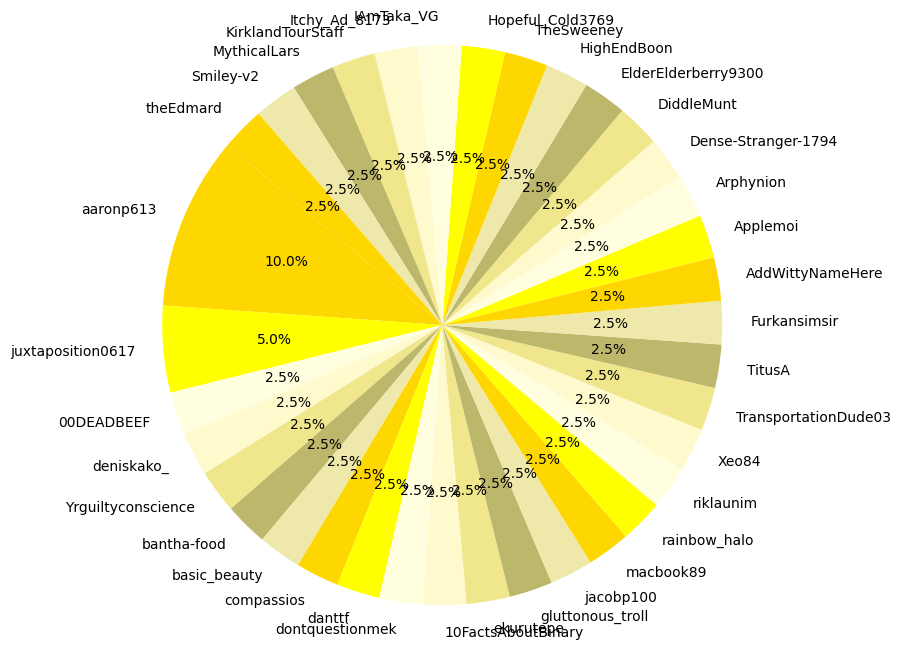

In [33]:
# Calculer le total des posts
total_posts = df_authors_sorted['number_of_posts'].sum()

# Calculer le pourcentage des posts totaux pour chaque auteur
df_authors_sorted['percentage'] = (df_authors_sorted['number_of_posts'] / total_posts) * 100

# Filtrer pour inclure seulement les auteurs avec plus de 1% des posts
df_filtered = df_authors_sorted[df_authors_sorted['percentage'] > 1]

# Couleurs en nuances de jaune
colors = ['gold', 'yellow', 'lightyellow', 'lemonchiffon', 'khaki', 'darkkhaki', 'palegoldenrod']

# Tracer le diagramme en camembert
plt.figure(figsize=(10, 8))
plt.pie(df_filtered['percentage'], labels=df_filtered['Auteur'], autopct='%1.1f%%',colors=colors, startangle=140)
plt.axis('equal')  # S'assurer que le camembert est bien circulaire
plt.show()

On remarque que deux utilisateurs se démarquent légèrement par leur nombre de posts réalisés sur APPLE. Ils ont publié respectivement 4 et 2 posts parmi ceux que nous avons gardé dans notre base de données nettoyée.

##  Statistiques sur les mots les plus utilisés

L'objectif de cette partie est de réaliser des **statistiques descriptives sur l'occurence de certains mots** dans les textes écrits dans les dataframes.

En partie II/A nous avons réalisé un nuage de mots permettant de rendre compte des mots les plus utilisés dans les titres des articles. On va maintenant créer un dataframe qui compte l'occurence des mots identifiés dans la section II/A

On ajoute le texte compilé des 5 commentaires les plus appréciés sous chaque post et on utilise les fonctions codées précédemment pour afficher les mots les plus fréquents.

In [36]:
# On regroupe le texte des colonnes de commentaires nettoyés en une seule colonne
df['comments_concatenated'] = df[['comment_1_clean', 'comment_2_clean', 'comment_3_clean', 'comment_4_clean', 'comment_5_clean']].apply(lambda x: ' '.join(x.dropna()), axis=1)

,Titre,Auteur,Texte,url,Cleaned_text,Top_Commentaires,comment_1,comment_2,comment_3,comment_4,comment_5,comment_1_clean,comment_2_clean,comment_3_clean,comment_4_clean,comment_5_clean,count,date2,cumulative_posts,comments_concatenated
Date,,,,,,,,,,,,,,,,,,,,
2023-12-24 12:37:24,"One year ago, I posted about my new app, Super...",compassios,"Hi everyone,\n\nAlmost one year ago, I [posted...",https://www.reddit.com/r/apple/comments/18pugs...,hi everyone almost one year ago posted launchh...,,I downloaded it and got the lifetime access. I...,I like it so far. Is there a connection to the...,I'm a pen and paper guy so I'm not the audienc...,"I'm genuinely impressed by this, especially co...",I’m never going to get past them being called ...,i downloaded it and got the lifetime access im...,i like it so far is there a connection to the ...,im a pen and paper guy so im not the audience ...,im genuinely impressed by this especially cons...,im never going to get past them being called c...,1,2023-12-24,1,i downloaded it and got the lifetime access im...
2023-12-24 10:50:08,Capture – Instantly Capture Your Thoughts on iOS,Furkansimsir,"Hi Reddit 👋,\n\nAs someone constantly juggling...",https://www.reddit.com/r/apple/comments/18psys...,hi reddit someone constantly juggling thoughts...,,i wonder what the correlation is between being...,Why would I subscribe to a notes app? There ar...,Why does this merit a subscription?,Why though? What problem is this solving?\n\nS...,Wasn't this posted last week?,i wonder what the correlation is between being...,why would i subscribe to a notes app there are...,why does this merit a subscription,why though what problem is this solving\n\nsee...,wasnt this posted last week,1,2023-12-24,2,i wonder what the correlation is between being...
2023-12-24 10:34:57,[30% OFF] Most Feature Complete Scientific Cal...,jacobp100,I’m a indie developer who since 2015 has been ...,https://www.reddit.com/r/apple/comments/18psrh...,im indie developer since working app would rep...,,I have technicalc and use it all the time! It’...,Does it support RPN(reverse Polish notation)?,The App Store says this has in-app purchases. ...,Man I wish I knew about this app when I was do...,Just bought it and I'm loving it already.\nI c...,i have technicalc and use it all the time its ...,does it support rpnreverse polish notation,the app store says this has inapp purchases ca...,man i wish i knew about this app when i was do...,just bought it and im loving it already\ni cam...,1,2023-12-24,3,i have technicalc and use it all the time its ...
2023-12-24 08:40:46,I've made a personal finance app. [Self-Promot...,deniskako_,"Hey everyone, first of all merry xmas and happ...",https://www.reddit.com/r/apple/comments/18pr9t...,hey everyone first merry xmas happy holidays w...,,I downloaded the app and was asked to review i...,Looks neat! The laurels aren’t real awards are...,"I like the design, congrats on publishing it!\...",Hi - this looks great. One question: what feat...,"""Editors Choice"", ""Finance apps we love"" - doe...",i downloaded the app and was asked to review i...,looks neat the laurels arent real awards are t...,i like the design congrats on publishing it\n\...,hi this looks great one question what feature...,editors choice finance apps we love doesnt th...,1,2023-12-24,4,i downloaded the app and was asked to review i...
2023-12-17 20:07:29,Made a Free Kids App About Animals [Sunday Sel...,juxtaposition0617,"Hi everyone - a few weeks ago, I posted about ...",https://www.reddit.com/r/apple/comments/18kpx4...,hi everyone weeks ago posted kids app animals ...,,Nice to see the improvements! The usability fa...,Pretty cool. \n\nAs a French speaker I usually...,I think my son is a tad too young for this at ...,I remember seeing this! Great to see the impro...,Any plans for Apple TV?,nice to see the improvements the usability fac...,pretty cool \n\nas a french speaker i usually ...,i think my son is a tad too young for this at ...,i r

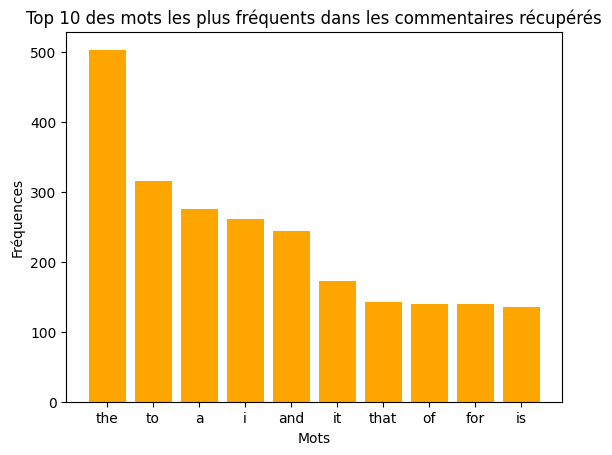

In [38]:
import matplotlib.pyplot as plt
from collections import Counter

df['Counting_Words']=df['comments_concatenated'].apply(count_common_words)
df['Most_common']=df['Counting_Words'].apply(most_common_words)
combined_dict_text=combine_dictionaries(df,'Most_common')

sorted_text_dictionary=sorted(combined_dict_text.items(), key= lambda item:item[1], reverse=True)[:10]

keys=[key for key, value in sorted_text_dictionary]
values=[value for key, value in sorted_text_dictionary]
color = 'orange'

plt.bar(keys, values, color=color)
plt.title("Top 10 des mots les plus fréquents dans les commentaires récupérés")
plt.xlabel('Mots')
plt.ylabel('Fréquences')
plt.show()

Il n'est pas étonnant de retrouver des **stopwords**. On les supprime et on affiche le nouveau graphique obtenu:

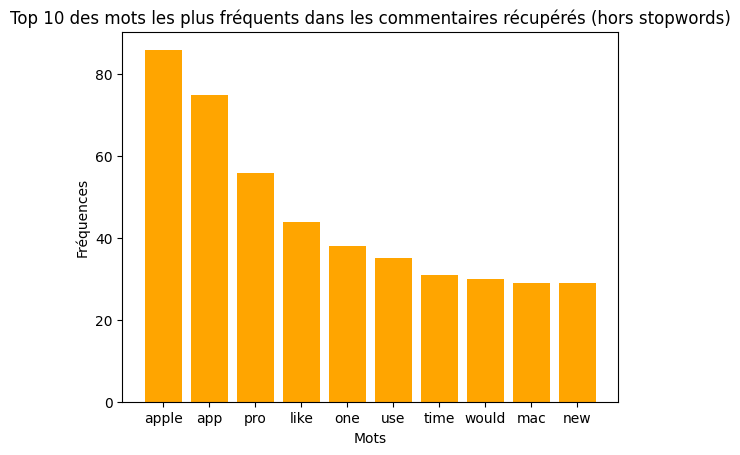

In [39]:
df['Comments_cleaned_stopwords']=df['comments_concatenated'].apply(clean_stopwords)

df['Counting_Words_nostopwords']=df['Comments_cleaned_stopwords'].apply(count_common_words)


combined_dict_text_bis=combine_dictionaries(df,'Counting_Words_nostopwords')
sorted_description_dictionary=sorted(combined_dict_text_bis.items(), key= lambda item:item[1], reverse=True)[:10]

keys=[key for key, value in sorted_description_dictionary]
values=[value for key, value in sorted_description_dictionary]


color='orange'

plt.bar(keys, values, color=color)
plt.title("Top 10 des mots les plus fréquents dans les commentaires récupérés (hors stopwords)")
plt.xlabel('Mots')
plt.ylabel('Fréquences')
plt.show()

Il n'est pas étonnant de retrouver des termes directement en lien avec la firme à la pomme en tête : apple, pro, ou  encore mac. 
Par ailleurs, les mots "app" et "new" peuvent laisser penser à une nouvelle sortie récente dont les utilisateurs parlent. Le mot "like" peut notamment laisser penser que les utilisateurs ont aimé cette nouveauté. On ne retrouve aucun mot à connotation négative et seulement ce mot connoté positivement. On imagine que le sentiment global qui ressort de ces commentaires est positif.

# Testons notre modèle LSTM entraîné dans Training.ipynb

On reprend le code déjà utilisé dans la partie sur les articles de presse.

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from transformers import pipeline
import numpy as np
import pandas as pd

n_words = 10000
tokenizer = Tokenizer(num_words=n_words)
tokenizer.fit_on_texts(df['comments_concatenated'])  

# On charge notre modèle entraîné
model_lstm = load_model('mon_modele_lstm.keras')

# On récupère le modèle transformers qui servira de référence
model_transformers = pipeline("sentiment-analysis")

On code deux fonctions qui nous permettrons de récupérer les prédictions de notre modèle LSTM:

In [51]:
def predict_lstm(text):
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=2209)
    prediction = model_lstm.predict(padded_sequence)
    return 'positive' if prediction > 0.7 else 'negative'

def get_majority_sentiment(sentiments):
    return max(set(sentiments), key=sentiments.count)


In [52]:
accurate=0
for index, row in df.iterrows():
    lstm_sentiments = []
    transformers_sentiments = []
    
    # ON fait des prédictions avec notre modèle et le modèle de référence pour chaque commentaire afin de tester la performance du modèle LSTM
    for col in ['comment_1_clean', 'comment_2_clean', 'comment_3_clean', 'comment_4_clean', 'comment_5_clean']:
        if pd.notnull(row[col]):
            lstm_sentiment = predict_lstm(row[col])
            lstm_sentiments.append(lstm_sentiment)
            
            transformers_result = model_transformers(row[col][:512])[0] #Il faut limiter la taille du texte à 512 caractères pour ce mmodèle comme vu précédemment
            transformers_sentiment = transformers_result['label'].lower()
            transformers_sentiments.append(transformers_sentiment)
    
    # Déterminer le sentiment majoritaire pour LSTM et Transformers
    lstm_majority_sentiment = get_majority_sentiment(lstm_sentiments)
    transformers_majority_sentiment = get_majority_sentiment(transformers_sentiments)
    if lstm_majority_sentiment==transformers_majority_sentiment:
        accurate+=1
    
print(accurate/(len(df)*5)*100)

1/1 [==============================] - 0s 39ms/step
12.0


In [53]:
print(f"Notre modèle LSTM est fiable à {accurate/(len(df)*5)*100}%")

Notre modèle LSTM est fiable à 12.0%


Ce n'est évidemment pas satisfaisant, nous utiliserons donc le modèle transformers pour notre algorithme de trading final.